In [0]:
# https://www.tensorflow.org/beta/tutorials/generative/dcgan
# https://www.kaggle.com/jessicali9530/celeba-dataset/home
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import drive
drive.mount('/content/drive/')
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
TensorFlow 2.x selected.


'2.0.0-beta1'

In [0]:
import glob, imageio, os, PIL, time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from IPython import display
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
  model = tf.keras.Sequential()
  
  model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
  
  model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2),padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)
  
  return model

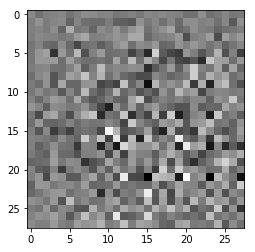

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  
  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  
  model.add(Flatten())
  model.add(Dense(1))
  
  return model

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00094025]], shape=(1, 1), dtype=float32)


In [0]:
# Определите потери и оптимизаторы
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Дискриминатор потеря
def discriminator_loss(real_output, fake_output):
  real_loss  = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss  = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Потеря генератора
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
checkpoint_dir = "/content/drive/My Drive/AI_APP_COLAB/Kaggle/GNA_FASION/My_Model_Checkpoint/"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# Определить тренировочный цикл

EPOCHS=50
noise_dim=100
num_examples_to_generate=16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)
    

In [0]:
# Генерация и сохранение изображений
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  
  fig = plt.figure(figsize=(4, 4))
  
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

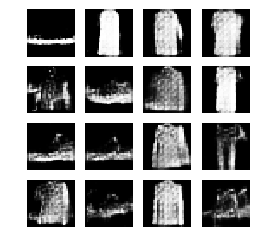

CPU times: user 2min 43s, sys: 41.2 s, total: 3min 24s
Wall time: 9min 49s


In [0]:
# Тренирем модель
%%time
train(train_dataset, EPOCHS)

In [0]:
# Восстановите последнюю контрольную точку.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

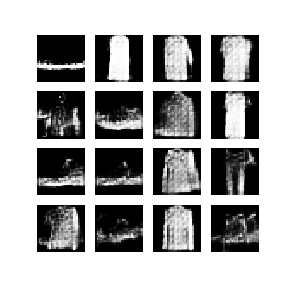

In [0]:
# Создать GIF

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)